In [129]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [130]:
def preprocess_data(file_path, lag=15, forecast=5):
    """Load and prepare data with lag features and target."""
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df.sort_values('Date', inplace=True)
    feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    for i in range(1, lag + 1):
        for col in feature_cols:
            df[f'{col}_lag{i}'] = df[col].shift(i)
    df['target'] = df['Close'].shift(-forecast)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    lag_cols = [f'{col}_lag{i}' for i in range(1, lag+1) for col in feature_cols]
    X = df[lag_cols]
    y = df['target']
    dates = df['Date']
    return df, X, y, dates


In [131]:
def split_data(X, y, dates, train_size=0.7, val_size=0.15):
    """Split features, target, and dates into train, validation, and test sets."""
    n = len(X)
    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))
    X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
    X_val, y_val     = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
    X_test, y_test   = X.iloc[val_end:],      y.iloc[val_end:]
    dates_test       = dates.iloc[val_end:]
    return (X_train, y_train), (X_val, y_val), (X_test, y_test, dates_test)


In [132]:
def calculate_metrics(y_true, y_pred):
    """Evaluate RMSE, MAPE, R², and directional accuracy."""
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    directional_acc = np.mean(np.sign(y_true[mask]) == np.sign(y_pred[mask]))
    return {'RMSE': rmse, 'MAPE (%)': mape, 'R2': r2, 'Directional Acc': directional_acc}


In [133]:
def run_linear_model(file_path, lag=15, forecast=5):
    """Run linear regression and compute return-based metrics."""
    df, X, y, dates = preprocess_data(file_path, lag, forecast)
    (X_train, y_train), (X_val, y_val), (X_test, y_test, dates_test) = split_data(X, y, dates)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)
    X_test_scaled  = scaler.transform(X_test)
    model = LinearRegression().fit(X_train_scaled, y_train)
    preds = {
        'Train': model.predict(X_train_scaled),
        'Validation': model.predict(X_val_scaled),
        'Test': model.predict(X_test_scaled)
    }
    metrics = {}
    split_points = {
        'Train': len(X_train),
        'Validation': len(X_train) + len(X_val)
    }
    for split, y_pred in preds.items():
        if split == 'Train':
            df_split = df.iloc[:split_points['Train']].reset_index(drop=True)
        elif split == 'Validation':
            df_split = df.iloc[split_points['Train']:split_points['Validation']].reset_index(drop=True)
        else:
            df_split = df.iloc[split_points['Validation']:].reset_index(drop=True)
        actual = df_split['target'].values
        price  = df_split['Close'].values
        ret_true = (actual - price) / price
        ret_pred = (y_pred - price) / price
        metrics[split] = calculate_metrics(ret_true, ret_pred)
    return metrics, model, dates_test, y_test.reset_index(drop=True), preds['Test']


In [134]:
def calculate_cash_balance(file_path, y_pred_test, notional=10000, lag=15, forecast=5):
    """Compute final cash values for model-driven and buy-and-hold strategies."""
    df, _, _, _ = preprocess_data(file_path, lag, forecast)
    test_start = int(len(df) * 0.85)
    df_test = df.iloc[test_start:].reset_index(drop=True)
    price  = df_test['Close'].values
    target = df_test['target'].values
    ret_pred   = (y_pred_test - price) / price
    ret_actual = (target - price) / price
    pnl = notional * ret_pred * ret_actual
    model_final_cash = notional + pnl.sum()
    buy_hold_cash    = notional * (price[-1] / price[0])
    return model_final_cash, buy_hold_cash, pnl


C:\Users\middl\AppData\Local\Temp\ipykernel_8912\1870328904.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag{i}'] = df[col].shift(i)
C:\Users\middl\AppData\Local\Temp\ipykernel_8912\1870328904.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag{i}'] = df[col].shift(i)
C:\Users\middl\AppData\Local\Temp\ipykernel_8912\1870328904.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining al

,RMSE,MAPE (%),R2,Directional Acc
Train,0.045108,213.925168,0.070949,0.615157
Validation,0.036055,237.808242,-0.279925,0.467456
Test,0.046292,183.357560,-0.137352,0.450246


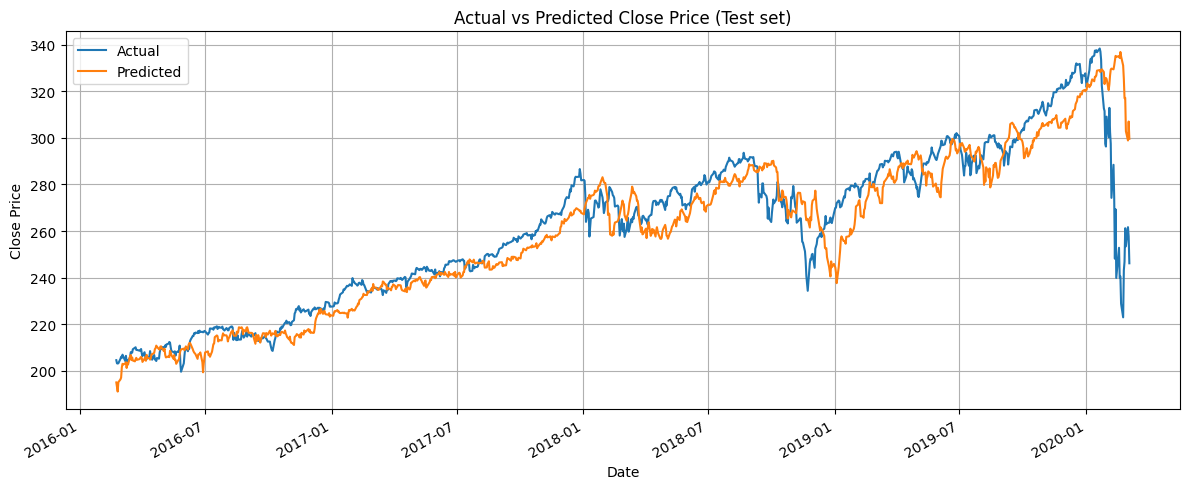

Buy-and-hold final cash: $16,267.68
Model-driven final cash: $9,814.70


C:\Users\middl\AppData\Local\Temp\ipykernel_8912\1870328904.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag{i}'] = df[col].shift(i)
C:\Users\middl\AppData\Local\Temp\ipykernel_8912\1870328904.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag{i}'] = df[col].shift(i)
C:\Users\middl\AppData\Local\Temp\ipykernel_8912\1870328904.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining al

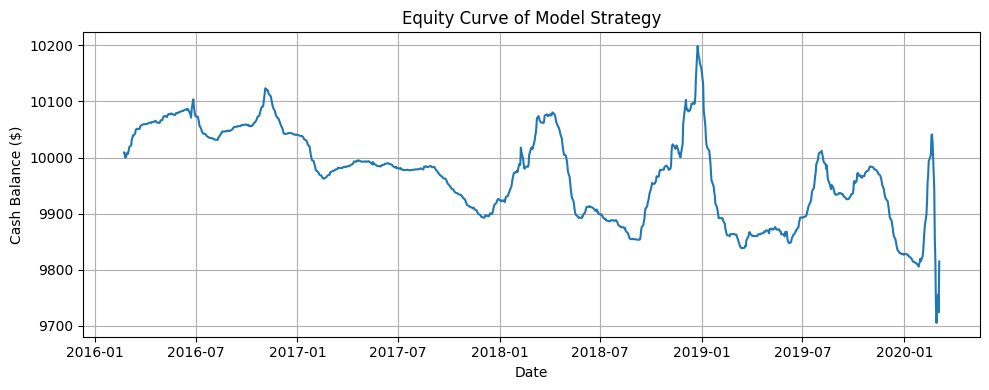

In [136]:
# Main execution for testing
file_path = '../data/etfs/SPY.csv'
lag = 60
forecast = 20

metrics, model, dates_test, y_test, y_pred_test = run_linear_model(file_path, lag, forecast)
metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
display(metrics_df)

# Plot actual vs predicted
actual_series = pd.Series(y_test.values, index=dates_test, name='Actual')
pred_series   = pd.Series(y_pred_test,     index=dates_test, name='Predicted')
plot_df = pd.concat([actual_series, pred_series], axis=1)
ax = plot_df.plot(figsize=(12, 5), grid=True)
ax.set_title("Actual vs Predicted Close Price (Test set)")
ax.set_xlabel("Date")
ax.set_ylabel("Close Price")
plt.tight_layout()
plt.show()

# Cash balance comparison
notional = 10000
model_cash, buy_hold_cash, pnl = calculate_cash_balance(file_path, y_pred_test, notional, lag, forecast)
print(f"Buy-and-hold final cash: ${buy_hold_cash:,.2f}")
print(f"Model-driven final cash: ${model_cash:,.2f}")

# Equity curve
equity = notional + np.cumsum(pnl)
plt.figure(figsize=(10, 4))
plt.plot(dates_test, equity)
plt.title("Equity Curve of Model Strategy")
plt.xlabel("Date")
plt.ylabel("Cash Balance ($)")
plt.grid(True)
plt.tight_layout()
plt.show()
